# Payoff d'un put spread (bear put) sur SPY

Spread baissier (long put haut, short put bas) : payoff borné, P&L net (prime BS) et point mort.


In [1]:

import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import sys
from pathlib import Path
from IPython.display import display, Markdown

_base = Path.cwd().resolve()
for extra in (_base, _base.parent, _base.parent.parent):
    candidate = extra / "notebooks" / "scripts"
    if candidate.exists() and str(candidate) not in sys.path:
        sys.path.insert(0, str(candidate))
        break
from pricing import fetch_spy_history, view_put_spread, payoff_put_spread
plt.style.use("seaborn-v0_8-darkgrid")

close_spy = fetch_spy_history()
spot_ref = float(close_spy.iloc[-1])

k_long = spot_ref * 1.02
k_short = spot_ref * 0.95
view_static = view_put_spread(spot_ref, k_long, k_short)
premium = view_static["premium"]
be, = view_static["breakevens"]


D:\PythonDProjects\PaperTradingApp\notebooks\scripts\pricing.py:47: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("SPY", period=period, interval=interval, progress=False)
C:\Users\nicol\AppData\Local\Temp\ipykernel_24012\2287992274.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spot_ref = float(close_spy.iloc[-1])


## Évolution du sous-jacent (SPY)
Historique des clôtures sur un an et repère du spot de référence (dernier close).


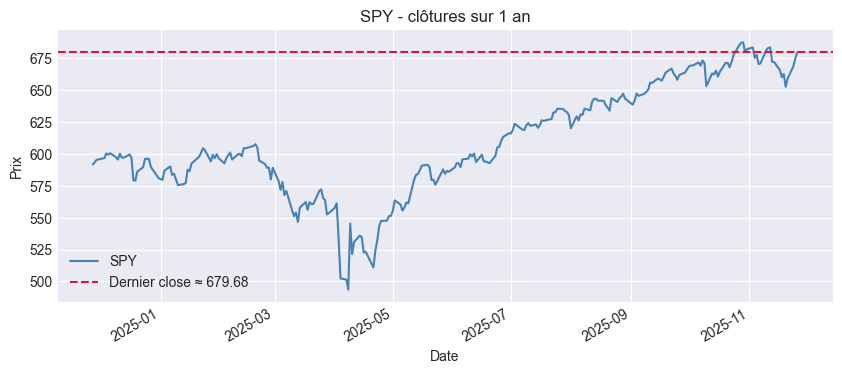

In [2]:

fig, ax = plt.subplots(figsize=(10, 4))
close_spy.plot(ax=ax, color="steelblue", label="SPY close")
ax.axhline(spot_ref, color="crimson", linestyle="--", label=f"Dernier close ≈ {spot_ref:.2f}")
ax.set_title("SPY - clôtures sur 1 an")
ax.set_xlabel("Date")
ax.set_ylabel("Prix")
ax.legend()
plt.show()


## Payoff du put spread long
Payoff borné, gain max = K_long - K_short - prime. Visualisation du payoff, P&L net et point mort.


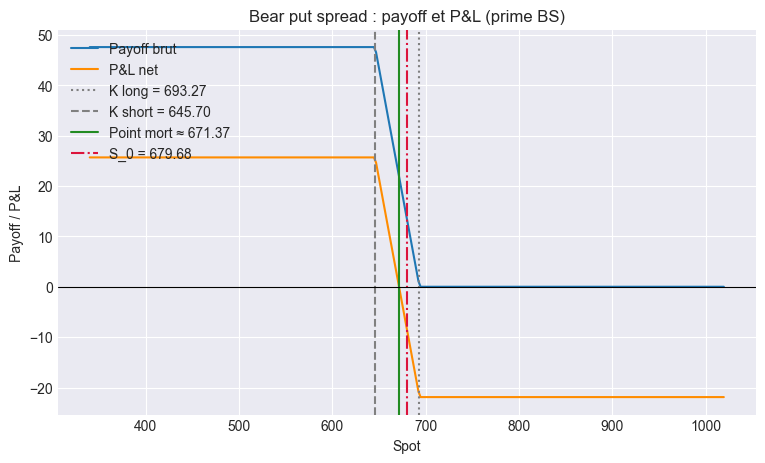

**Prime (BS) ≈ 21.9012** | **Point mort ≈ 671.37**

In [3]:

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(view_static["s_grid"], view_static["payoff"], label="Payoff brut")
ax.plot(view_static["s_grid"], view_static["pnl"], label="P&L net", color="darkorange")
ax.axvline(k_long, color="gray", linestyle=":", label=f"K long = {k_long:.2f}")
ax.axvline(k_short, color="gray", linestyle="--", label=f"K short = {k_short:.2f}")
ax.axvline(be, color="forestgreen", linestyle="-", label=f"Point mort ≈ {be:.2f}")
ax.axvline(spot_ref, color="crimson", linestyle="-.", label=f"S_0 = {spot_ref:.2f}")
ax.axhline(0, color="black", linewidth=0.8)
ax.set_xlabel("Spot")
ax.set_ylabel("Payoff / P&L")
ax.set_title("Bear put spread : payoff et P&L (prime BS)")
ax.legend(loc="upper left")
plt.show()

display(Markdown(f"""**Prime (BS) ≈ {premium:.4f}** | **Point mort ≈ {be:.2f}**"""))


## Payoff interactif
Curseurs pour ajuster S_0, S_T, K long et K short. Prime et point mort recalculés à la volée.


In [4]:

spot0_slider = widgets.FloatSlider(value=spot_ref, min=spot_ref*0.5, max=spot_ref*1.5, step=1.0, description='S_0')
spotT_slider = widgets.FloatSlider(value=spot_ref, min=spot_ref*0.5, max=spot_ref*1.5, step=1.0, description='S_T')
slider_long = widgets.FloatSlider(value=k_long, min=spot_ref*0.6, max=spot_ref*1.6, step=1.0, description='K long')
slider_short = widgets.FloatSlider(value=k_short, min=spot_ref*0.4, max=spot_ref*1.2, step=1.0, description='K short')
output = widgets.Output()

def _update_payoff(change=None):
    with output:
        output.clear_output()
        s0 = spot0_slider.value
        sT = spotT_slider.value
        k_long_val = slider_long.value
        k_short_val = slider_short.value

        view_dyn = view_put_spread(s0, k_long_val, k_short_val)
        premium_dyn = view_dyn["premium"]
        be, = view_dyn["breakevens"]
        payoff_T = float(payoff_put_spread(sT, k_long_val, k_short_val))
        pnl_T = payoff_T - premium_dyn

        fig, ax = plt.subplots(figsize=(7, 4))
        ax.plot(view_dyn["s_grid"], view_dyn["payoff"], label='Payoff brut')
        ax.plot(view_dyn["s_grid"], view_dyn["pnl"], label='P&L net', color='darkorange')
        ax.axvline(k_long_val, color='gray', linestyle=':', label=f'K long = {k_long_val:.2f}')
        ax.axvline(k_short_val, color='gray', linestyle='--', label=f'K short = {k_short_val:.2f}')
        ax.axvline(be, color='forestgreen', linestyle='-', label=f'Point mort ≈ {be:.2f}')
        ax.axvline(s0, color='crimson', linestyle='-.', label=f'S_0 = {s0:.2f}')
        ax.axhline(0, color='black', linewidth=0.8)
        ax.scatter([sT], [pnl_T], color='gold', zorder=5, label=f'P&L à S_T = {pnl_T:.2f}')
        ax.set_xlabel('Spot')
        ax.set_ylabel('Payoff / P&L')
        ax.legend(loc='lower right')
        ax.set_title('Payoff et P&L du put spread')
        plt.show()

        display(Markdown(f"""**S_0 = {s0:.2f}**, **S_T = {sT:.2f}**

- K long = {k_long_val:.2f}
- K short = {k_short_val:.2f}
- Prix (BS) = {premium_dyn:.4f}
- Payoff à l'expiration = {payoff_T:.4f}
- P&L net = {pnl_T:.4f}
- Point mort ≈ {be:.2f}"""))

for sl in (spot0_slider, spotT_slider, slider_long, slider_short):
    sl.observe(_update_payoff, names='value')

_update_payoff()
display(widgets.VBox([spot0_slider, spotT_slider, slider_long, slider_short, output]))
